### **Preprocessing steps for ABCD, GESTE, and BANDA.**

This notebook will perform various preprocessing steps such as: 

1. Harmonization across sites for the ABCD data.
1. Residualization (individually for all datasets.)
1. Factor analysis (EFA and CFA) on cognitive data to extract cognitive factor.
1. Harmonization between datasets (using the ABCD as reference dataset).
1. Imputation of missing values.

### **Harmonization of the ABCD data across site.**

The next cells will perform harmonization within the ABCD dataset using the neuroCombat package. Only cognitive and behavioral variables will be harmonized.

In [1]:
# Imports
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.impute import KNNImputer
from statsmodels.regression.linear_model import OLS

from neurostatx.statistics.harmonization import neuroCombat
from neurostatx.io.utils import load_df_in_any_format
from neurostatx.utils.preprocessing import merge_dataframes

In [2]:
# Setting up relevant paths.
repository_path = "/Users/anthonygagnon/code/Article-s-Code/" # CHANGE THIS
abcd_base_path = "/Volumes/T7/CCPM/ABCD/Release_5.1/abcd-data-release-5.1/" # CHANGE THIS
geste_base_dir = "/Volumes/T7/CCPM/GESTE/" # CHANGE THIS
banda_dir = '/Volumes/T7/CCPM/BANDA/BANDARelease1.1/' # CHANGE THIS
output_folder = "/Volumes/T7/CCPM/RESULTS_JUNE_24/" # CHANGE THIS
data_dir = f"{output_folder}/datagathering/"
output_dir = f"{output_folder}/preprocessing/"

# Create output directory if it does not exist.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [3]:
# Load ABCD data.
abcd_data = load_df_in_any_format(f'{data_dir}/abcd_data.xlsx')

/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_9477/1152007989.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


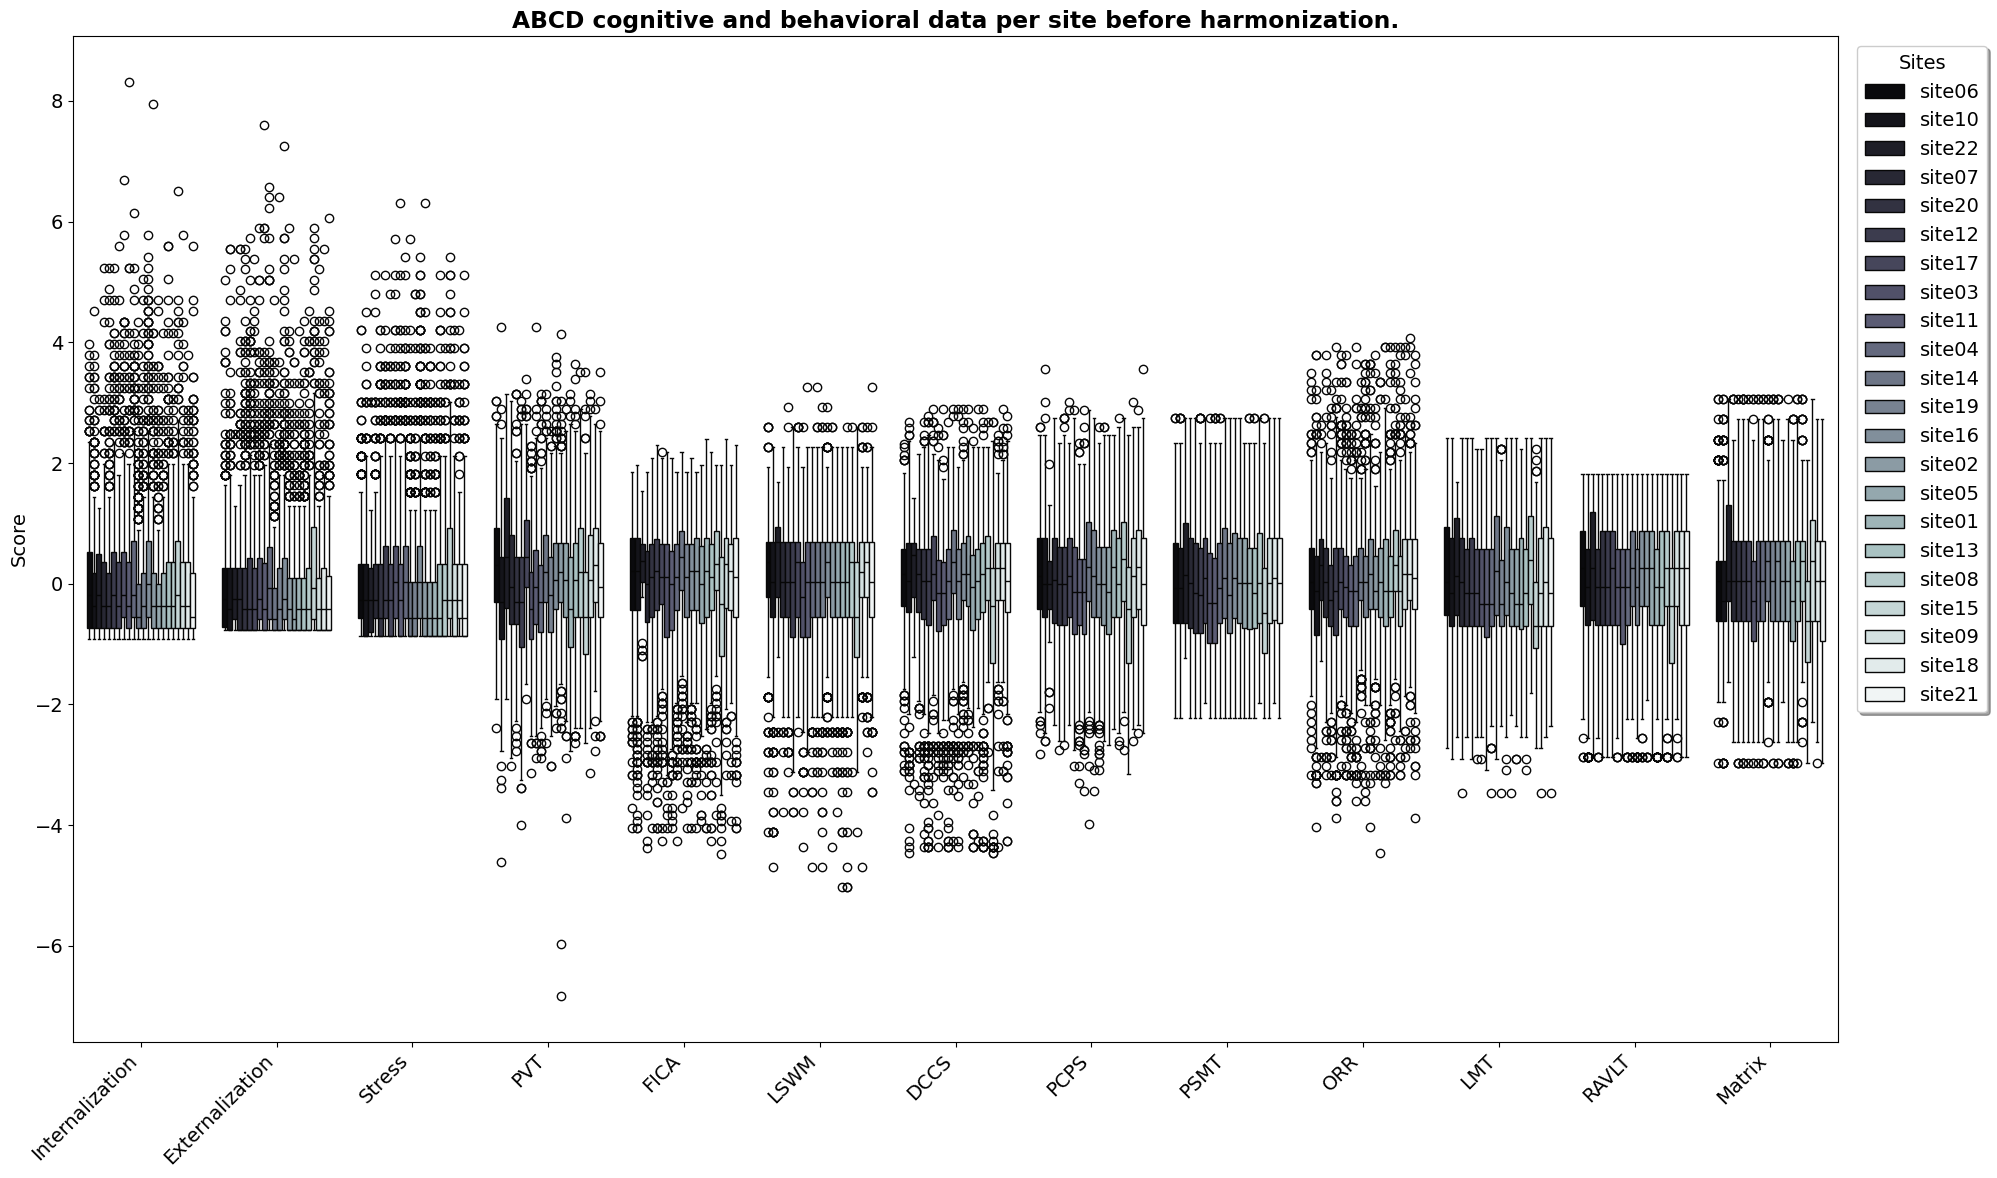

In [4]:
# Subset the data to only include the relevant columns.
abcd_for_viz = abcd_data[['Site', 'Internalization', 'Externalization',
                                    'Stress', 'PictureVocab', 'Flanker', 'ListSorting',
                                    'CardSort', 'PatternComparison', 'PictureSequence',
                                    'OralReading', 'LMT', 'RAVLT', 'WISCMatrix']]
abcd_for_viz = abcd_for_viz.melt(id_vars=['Site'])

# Setting list for xticklabel.
xticks = ['Internalization', 'Externalization', 'Stress', 'PVT', 'FICA',
          'LSWM', 'DCCS', 'PCPS', 'PSMT', 'ORR', 'LMT', 'RAVLT', 'Matrix']

# Setting plotting parameters.
params = {
    "data": abcd_for_viz,
    "x": "variable",
    "y": "value",
    "hue": "Site",
    "palette": "bone",
    "saturation": 0.8,
    "orient": "v",
}


with plt.rc_context(
        {"font.family": "Sans Serif",
         "font.size": 14, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    sns.boxplot(**params, ax=ax)

    # Customizing the plot.
    ax.set_title("ABCD cognitive and behavioral data per site before harmonization.")
    ax.set_ylabel("Score")
    ax.set_xlabel("")
    ax.set_xticklabels(xticks)
    ax.figure.autofmt_xdate(rotation=45, ha='right')
    ax.legend(loc="upper right", bbox_to_anchor=(1.09, 1.0), title="Sites", title_fontsize="medium",
              shadow=True, fancybox=True)

    plt.tight_layout()
    plt.show()
    

In [5]:
# Performing harmonization
vars_to_harmonize = ["Internalization", "Externalization", "Stress", "PictureVocab",
                     "Flanker", "ListSorting", "CardSort", "PatternComparison",
                     "PictureSequence", "OralReading", "LMT", "RAVLT", "WISCMatrix"]
abcd_for_harm = abcd_data[vars_to_harmonize]
abcd_covars = abcd_data[["Site"]]

# Harmonizing the data.
abcd_harmonized = neuroCombat(abcd_for_harm.values.T, abcd_covars, batch_col="Site",
                              eb=True, parametric=True)

/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_9477/1843079283.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


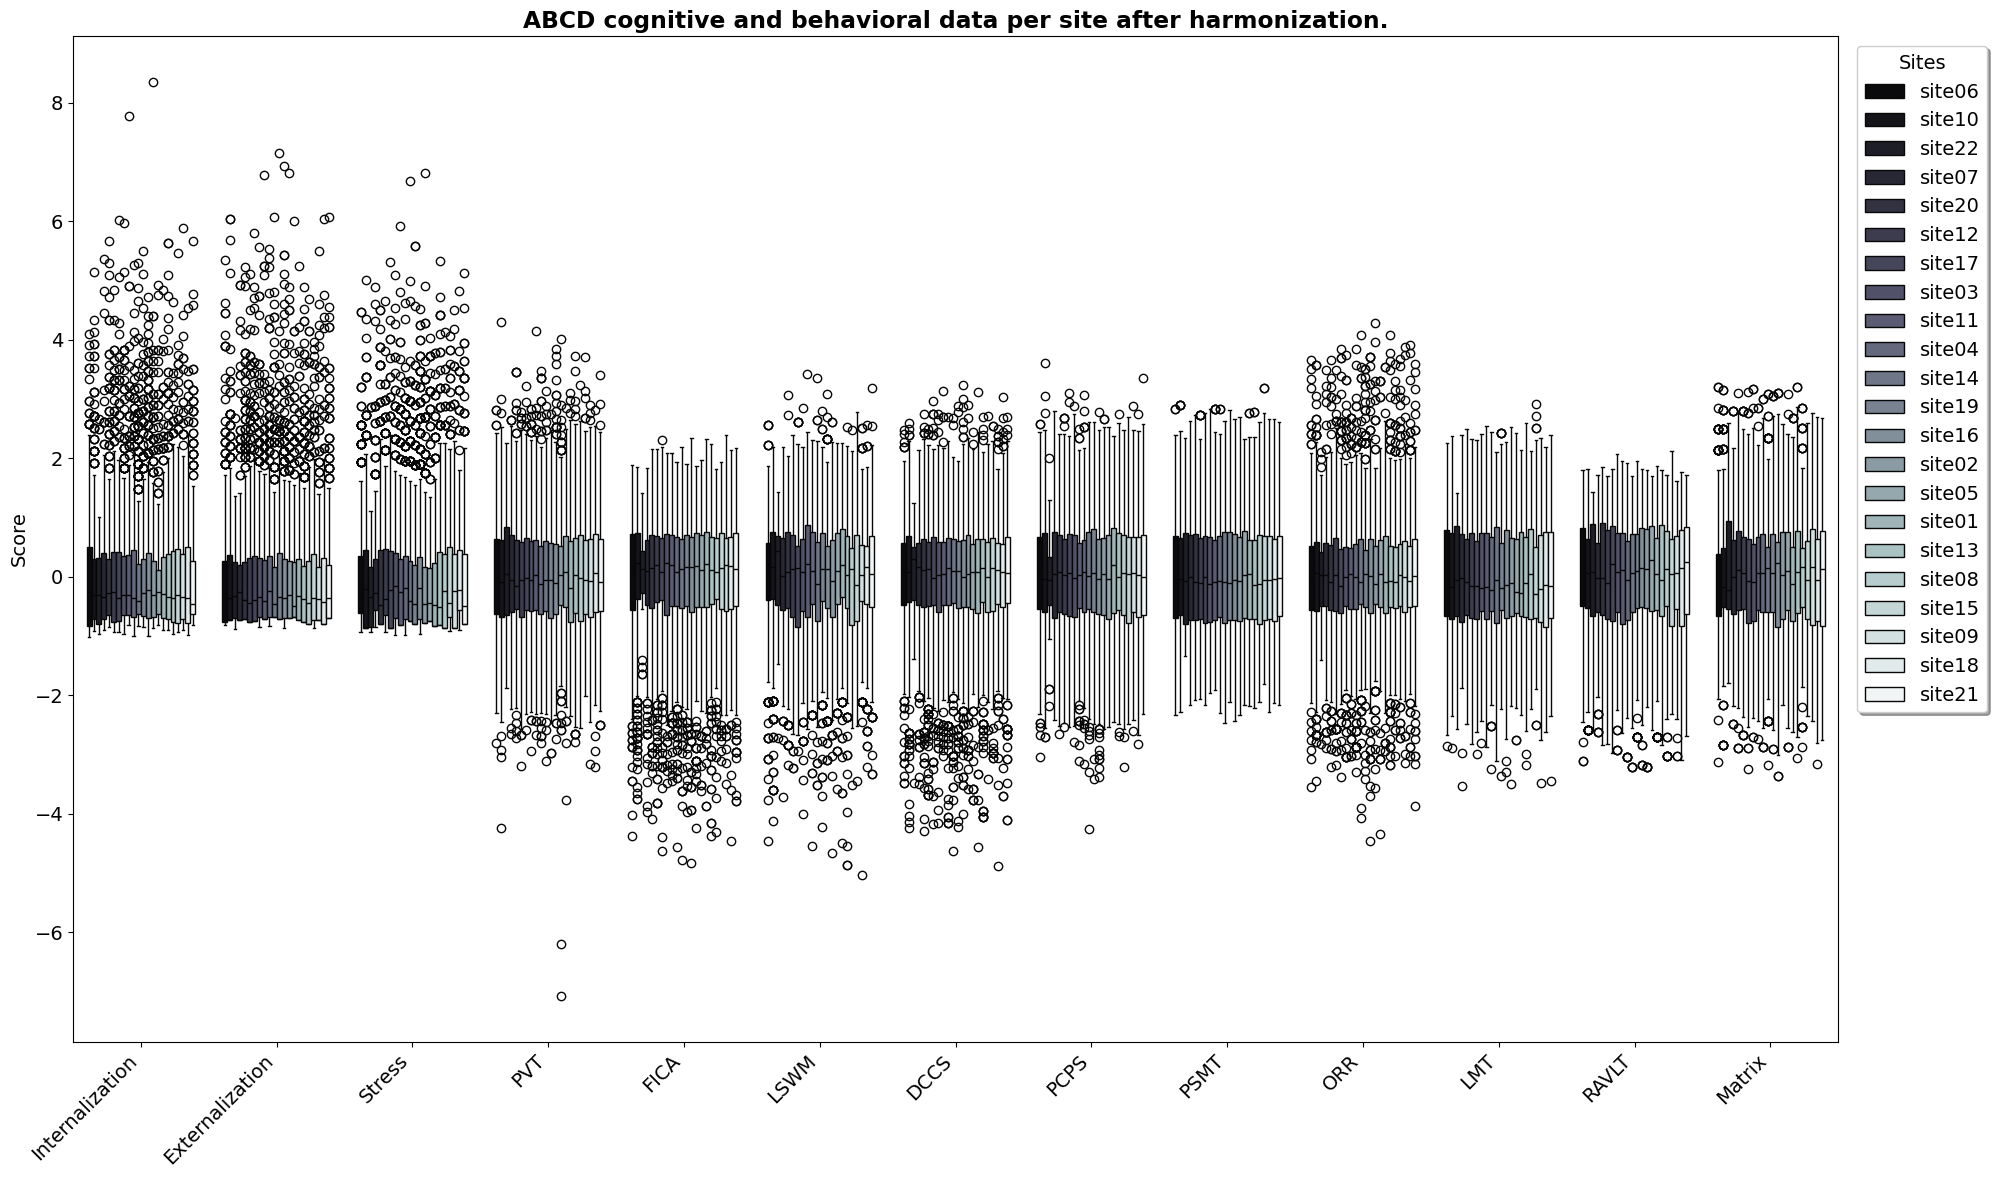

In [6]:
# Plotting the newly harmonized data.
abcd_post_harm_viz = pd.DataFrame(abcd_harmonized['data'].T, columns=vars_to_harmonize)
abcd_post_harm_viz = pd.concat([abcd_data["Site"], abcd_post_harm_viz], axis=1)

# Melt the data for visualization.
abcd_post_harm_viz = abcd_post_harm_viz.melt(id_vars=['Site'])

# Setting plotting parameters.
params = {
    "data": abcd_post_harm_viz,
    "x": "variable",
    "y": "value",
    "hue": "Site",
    "palette": "bone",
    "saturation": 0.8,
    "orient": "v",
}


with plt.rc_context(
        {"font.family": "Sans Serif",
         "font.size": 14, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    sns.boxplot(**params, ax=ax)

    # Customizing the plot.
    ax.set_title("ABCD cognitive and behavioral data per site after harmonization.")
    ax.set_ylabel("Score")
    ax.set_xlabel("")
    ax.set_xticklabels(xticks)
    ax.figure.autofmt_xdate(rotation=45, ha='right')
    ax.legend(loc="upper right", bbox_to_anchor=(1.09, 1.0), title="Sites", title_fontsize="medium",
              shadow=True, fancybox=True)

    plt.tight_layout()
    plt.show()

In [7]:
# Merging back with the original data.
abcd_data_harmonized = pd.concat([abcd_data.drop(columns=vars_to_harmonize),
                       pd.DataFrame(abcd_harmonized['data'].T)], axis=1)
abcd_data_harmonized.columns = abcd_data.columns

# Commented out since data is protected by an DUC.
# abcd_data_harmonized.head()

#### **Residualization of covariates from cognitive and behavioral data.**

Following cells will regress those covariates from the cognitive and behavioral data independently for each cohort:

1. Sex
1. Age
1. Handedness
1. Ethnicity

#### **Regressing out covariates in the ABCD Study.**

In [8]:
# Keeping the harmonized data computed above.
covars = ["Sex", "AgeMonths", "Ethnicity", "Handedness"]
vars = ["Internalization", "Externalization", "Stress", "PictureVocab",
        "Flanker", "ListSorting", "CardSort", "PatternComparison",
        "PictureSequence", "OralReading", "LMT", "RAVLT", "WISCMatrix"]

# Instantiating an empty df to store the results.
residuals = pd.DataFrame()

# Running a linear regression model for each variable.
for var in vars:
    model = OLS(abcd_data_harmonized[var].values, abcd_data_harmonized[covars].values)
    results = model.fit()
    residuals[var] = results.resid

In [9]:
# Merging the residuals with the original data.
abcd_data_resid = pd.concat([abcd_data_harmonized.drop(columns=vars),
                             residuals], axis=1)

# Saving the residualized data.
abcd_data_resid.to_excel(f'{output_dir}/abcd_data_residualized.xlsx', index=False, header=True)

#### **Regressing out covariates in the BANDA Study.**

In [10]:
# Load BANDA data.
banda_data = load_df_in_any_format(f'{data_dir}/banda_data.xlsx')

In [11]:
# Setting the variables to use in residualization.
covars = ["Sex", "AgeMonths", "Ethnicity", "Handedness"]
vars = ["Internalization", "Externalization", 'Stress', 'DCCS', 'Flanker', 'ListSorting',
        'OralReading', 'PatternComparison', 'PennWM', 'PennMatrix', 'WASIVocabulary']

# Instantiating an empty df to store the results.
residuals = pd.DataFrame()

# Running a linear regression model for each variable.
for var in vars:
    model = OLS(banda_data[var].values.astype("float"), banda_data[covars].values.astype("float"))
    results = model.fit()
    residuals[var] = results.resid

In [12]:
# Merging the residuals with the original data.
banda_data_resid = pd.concat([banda_data.drop(columns=vars),
                              residuals], axis=1)

# Saving the residualized data.
banda_data_resid.to_excel(f'{output_dir}/banda_data_residualized.xlsx', index=False, header=True)

#### **Regressing out covariates in the GESTE Study.**

In [13]:
# Load GESTE data.
geste_data = load_df_in_any_format(f'{data_dir}/geste_data.xlsx')

In [14]:
# Setting the variables to use in residualization.
covars = ["Sex", "AgeMonths", "Ethnicity", "Handedness"]
vars = ["Internalization", "Externalization", "Block", "Similarities",
        "MatrixReasoning", "DigitSpan", "Code", "Vocabulary", "Balance"]

# Instantiating an empty df to store the results.
residuals = pd.DataFrame()

# Running a linear regression model for each variable.
for var in vars:
    model = OLS(geste_data[var].values.astype("float"), geste_data[covars].values.astype("float"))
    results = model.fit()
    residuals[var] = results.resid

In [15]:
# Merging the residuals with the original data.
geste_data_resid = pd.concat([geste_data.drop(columns=vars),
                              residuals], axis=1)

# Saving the residualized data.
geste_data_resid.to_excel(f'{output_dir}/geste_data_residualized.xlsx', index=False, header=True)

#### **Computing the cognitive factor for each study.**

Following [1], the factor structure of the cognitive data from the ABCD dataset can be summarized using a combined exploratory and confirmatory factorial analysis. Here, we apply this method on the ABCD data, and extend it to GESTE and BANDA.

[1] Moore, Dawn Michele, and Andrew R. A. Conway. “The Structure of Cognitive Abilities and Associations with Problem Behaviors in Early Adolescence: An Analysis of Baseline Data from the Adolescent Brain Cognitive Development Study.” Journal of Intelligence 11, no. 5 (May 10, 2023): 90. https://doi.org/10.3390/jintelligence11050090.

**The next section is run using CLI python scripts within the [NeuroStatX](https://github.com/gagnonanthony/NeuroStatX.git) toolbox. Simply executing the cells below will run the underlying CLI script, but it might be less efficient. For a more optimized execution, run the CLI directly in your terminal window.**

#### **Running an exploratory and confirmatory factorial analysis on ABCD cognitive data.**

In [33]:
# Using the residualized data for further analysis (saved on disk) and running the CLI script from the command line.
!ExploratoryFA --in-dataset {output_dir}/abcd_data_residualized.xlsx --out-folder {output_dir}/ABCD_EFA/ \
    --id-column subjectkey --desc-columns 24 --rotation oblimin --method minres --train_dataset_size 0.5 \
    -v -s -f --random_state 1234 --nb_factors 3

2024-06-25 15:37:24 Anthonys-MBP.med.usherbrooke.ca root[88680] INFO Validating input files and creating output folder /Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//ABCD_EFA/
2024-06-25 15:37:24 Anthonys-MBP.med.usherbrooke.ca root[88680] INFO Loading ['/Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//abcd_data_residualized.xlsx']
2024-06-25 15:37:26 Anthonys-MBP.med.usherbrooke.ca root[88680] INFO Splitting into train and test datasets. Using training dataset for EFA.
2024-06-25 15:37:29 Anthonys-MBP.med.usherbrooke.ca root[88680] INFO Bartlett's test of sphericity returned a p-value of 0.0 and Keiser-Meyer-Olkin (KMO)test returned a value of 0.8509001593017482.


In [34]:
!ConfirmatoryFA --in-dataset {output_dir}/ABCD_EFA/test_dataset.xlsx --out-folder {output_dir}/ABCD_CFA/ \
    --id-column subjectkey --desc-columns 24 \
    --model "VA =~ OralReading + PictureVocab + ListSorting" \
    --model "EFPS =~ PatternComparison + CardSort + Flanker" \
    --model "MEM =~ PictureSequence + RAVLT + ListSorting" \
    -v -s -f

2024-06-25 15:37:36 Anthonys-MBP.med.usherbrooke.ca root[88831] INFO Validating input files and creating output folder /Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//ABCD_CFA/
2024-06-25 15:37:36 Anthonys-MBP.med.usherbrooke.ca root[88831] INFO Loading ['/Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//ABCD_EFA/test_dataset.xlsx']
2024-06-25 15:37:37 Anthonys-MBP.med.usherbrooke.ca root[88831] INFO Performing Confirmatory Factorial Analysis (CFA) with the following model specification:
VA =~ OralReading + PictureVocab + ListSorting
EFPS =~ PatternComparison + CardSort + Flanker
MEM =~ PictureSequence + RAVLT + ListSorting

2024-06-25 15:37:37 Anthonys-MBP.med.usherbrooke.ca root[88831] INFO Exporting results and statistics.


In [35]:
# Applying the CFA model on the raw data.
!ApplyModel --in-dataset {output_dir}/abcd_data_residualized.xlsx --out-folder {output_dir}/ABCD_CFA_Apply/ \
    --id-column subjectkey --desc-columns 24 --model {output_dir}/ABCD_CFA/cfa_model.pkl -v -s -f

2024-06-25 15:37:41 Anthonys-MBP.med.usherbrooke.ca root[88915] INFO Validating input files and creating output folder /Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//ABCD_CFA_Apply/
2024-06-25 15:37:41 Anthonys-MBP.med.usherbrooke.ca root[88915] INFO Loading ['/Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//abcd_data_residualized.xlsx']
2024-06-25 15:37:43 Anthonys-MBP.med.usherbrooke.ca root[88915] INFO Loading model
2024-06-25 15:37:43 Anthonys-MBP.med.usherbrooke.ca root[88915] INFO Applying model
2024-06-25 15:37:43 Anthonys-MBP.med.usherbrooke.ca root[88915] INFO Saving transformed dataset


#### **Running an exploratory and confirmatory factorial analysis on BANDA cognitive data.**

In [45]:
# Using the residualized data for further analysis (saved on disk) and running the CLI script from the command line.
!ExploratoryFA --in-dataset {output_dir}/banda_data_residualized.xlsx --out-folder {output_dir}/BANDA_EFA/ \
    --id-column subjectkey --desc-columns 19 --rotation oblimin --method minres --train_dataset_size 0.5 \
    -v -s -f --random_state 1234 --nb_factors 3

2024-06-25 15:38:40 Anthonys-MBP.med.usherbrooke.ca root[89497] INFO Validating input files and creating output folder /Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//BANDA_EFA/
2024-06-25 15:38:40 Anthonys-MBP.med.usherbrooke.ca root[89497] INFO Loading ['/Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//banda_data_residualized.xlsx']
2024-06-25 15:38:40 Anthonys-MBP.med.usherbrooke.ca root[89497] INFO Splitting into train and test datasets. Using training dataset for EFA.
2024-06-25 15:38:40 Anthonys-MBP.med.usherbrooke.ca root[89497] INFO Bartlett's test of sphericity returned a p-value of 8.0389624481719125e-28 and Keiser-Meyer-Olkin (KMO)test returned a value of 0.7770098461481931.


In [46]:
!ConfirmatoryFA --in-dataset {output_dir}/BANDA_EFA/test_dataset.xlsx --out-folder {output_dir}/BANDA_CFA/ \
    --id-column subjectkey --desc-columns 19 \
    --model "VA =~ OralReading + WASIVocabulary + ListSorting" \
    --model "EFPS =~ DCCS + Flanker + PatternComparison" \
    --model "MEM =~ PennWM + PennMatrix + ListSorting" \
    -v -s -f

2024-06-25 15:38:44 Anthonys-MBP.med.usherbrooke.ca root[89511] INFO Validating input files and creating output folder /Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//BANDA_CFA/
2024-06-25 15:38:44 Anthonys-MBP.med.usherbrooke.ca root[89511] INFO Loading ['/Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//BANDA_EFA/test_dataset.xlsx']
2024-06-25 15:38:44 Anthonys-MBP.med.usherbrooke.ca root[89511] INFO Performing Confirmatory Factorial Analysis (CFA) with the following model specification:
VA =~ OralReading + WASIVocabulary + ListSorting
EFPS =~ DCCS + Flanker + PatternComparison
MEM =~ PennWM + PennMatrix + ListSorting

2024-06-25 15:38:45 Anthonys-MBP.med.usherbrooke.ca root[89511] INFO Exporting results and statistics.


In [47]:
# Applying the CFA model on the raw data.
!ApplyModel --in-dataset {output_dir}/banda_data_residualized.xlsx --out-folder {output_dir}/BANDA_CFA_Apply/ \
    --id-column subjectkey --desc-columns 19 --model {output_dir}/BANDA_CFA/cfa_model.pkl -v -s -f

2024-06-25 15:38:51 Anthonys-MBP.med.usherbrooke.ca root[89568] INFO Validating input files and creating output folder /Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//BANDA_CFA_Apply/
2024-06-25 15:38:51 Anthonys-MBP.med.usherbrooke.ca root[89568] INFO Loading ['/Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//banda_data_residualized.xlsx']
2024-06-25 15:38:51 Anthonys-MBP.med.usherbrooke.ca root[89568] INFO Loading model
2024-06-25 15:38:51 Anthonys-MBP.med.usherbrooke.ca root[89568] INFO Applying model
2024-06-25 15:38:51 Anthonys-MBP.med.usherbrooke.ca root[89568] INFO Saving transformed dataset


#### **Running an exploratory and confirmatory factorial analysis on GESTE cognitive data.**

In [39]:
# Using the residualized data for further analysis (saved on disk) and running the CLI script from the command line.
!ExploratoryFA --in-dataset {output_dir}/geste_data_residualized.xlsx --out-folder {output_dir}/GESTE_EFA/ \
    --id-column subjectkey --desc-columns 15 --rotation oblimin --method minres --train_dataset_size 0.5 \
    -v -s -f --random_state 1234 --nb_factors 3

2024-06-25 15:37:55 Anthonys-MBP.med.usherbrooke.ca root[89111] INFO Validating input files and creating output folder /Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//GESTE_EFA/
2024-06-25 15:37:55 Anthonys-MBP.med.usherbrooke.ca root[89111] INFO Loading ['/Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//geste_data_residualized.xlsx']
2024-06-25 15:37:55 Anthonys-MBP.med.usherbrooke.ca root[89111] INFO Splitting into train and test datasets. Using training dataset for EFA.
2024-06-25 15:37:55 Anthonys-MBP.med.usherbrooke.ca root[89111] INFO Bartlett's test of sphericity returned a p-value of 4.907663660496039e-17 and Keiser-Meyer-Olkin (KMO)test returned a value of 0.6057040453369615.


In [40]:
!ConfirmatoryFA --in-dataset {output_dir}/GESTE_EFA/test_dataset.xlsx --out-folder {output_dir}/GESTE_CFA/ \
    --id-column subjectkey --desc-columns 15 \
    --model "VA =~ Vocabulary + Similarities" \
    --model "EFPS =~ Code" \
    --model "MEM =~ Block + Balance + DigitSpan + MatrixReasoning" \
    -v -s -f

2024-06-25 15:37:59 Anthonys-MBP.med.usherbrooke.ca root[89167] INFO Validating input files and creating output folder /Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//GESTE_CFA/
2024-06-25 15:37:59 Anthonys-MBP.med.usherbrooke.ca root[89167] INFO Loading ['/Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//GESTE_EFA/test_dataset.xlsx']
2024-06-25 15:38:00 Anthonys-MBP.med.usherbrooke.ca root[89167] INFO Performing Confirmatory Factorial Analysis (CFA) with the following model specification:
VA =~ Vocabulary + Similarities
EFPS =~ Code
MEM =~ Block + Balance + DigitSpan + MatrixReasoning

2024-06-25 15:38:00 Anthonys-MBP.med.usherbrooke.ca root[89167] WARNING Fisher Information Matrix is not PD.Moore-Penrose inverse will be used instead of Cholesky decomposition. See 10.1109/TSP.2012.2208105.
2024-06-25 15:38:00 Anthonys-MBP.med.usherbrooke.ca root[89167] INFO Exporting results and statistics.
2024-06-25 15:38:00 Anthonys-MBP.med.usherbrooke.ca root[89167] WARNING Fisher Information Matr

In [41]:
!ApplyModel --in-dataset {output_dir}/geste_data_residualized.xlsx --out-folder {output_dir}/GESTE_CFA_Apply/ \
    --id-column subjectkey --desc-columns 15 --model {output_dir}/GESTE_CFA/cfa_model.pkl -v -s -f

2024-06-25 15:38:02 Anthonys-MBP.med.usherbrooke.ca root[89202] INFO Validating input files and creating output folder /Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//GESTE_CFA_Apply/
2024-06-25 15:38:02 Anthonys-MBP.med.usherbrooke.ca root[89202] INFO Loading ['/Volumes/T7/CCPM/RESULTS_JUNE_24//preprocessing//geste_data_residualized.xlsx']
2024-06-25 15:38:02 Anthonys-MBP.med.usherbrooke.ca root[89202] INFO Loading model
2024-06-25 15:38:02 Anthonys-MBP.med.usherbrooke.ca root[89202] INFO Applying model
2024-06-25 15:38:02 Anthonys-MBP.med.usherbrooke.ca root[89202] INFO Saving transformed dataset


#### **Harmonization between the three studies.**

Since distribution range is highly important when performing clustering due to the use of distance metrics between individual subjects and cluster's centroids, we perform harmonization between cognitive and behavioral data between the three studies using ABCD as the reference. This also removes non-biological effect related to type of instrument use, human intervention, etc.

In [23]:
# Load the results of the CFA analysis for all studies.
abcd_cfa = load_df_in_any_format(f'{output_dir}/ABCD_CFA_Apply/transformed_dataset.xlsx')
banda_cfa = load_df_in_any_format(f'{output_dir}/BANDA_CFA_Apply/transformed_dataset.xlsx')
geste_cfa = load_df_in_any_format(f'{output_dir}/GESTE_CFA_Apply/transformed_dataset.xlsx')

In [24]:
# Adding an empty column (filled with 0) in the GESTE dataset to reproduce the Stress problems score.
# Will be deleted after harmonization. 
geste_cfa.loc[:, 'Stress'] = 0

# Subsetting the data to only include the relevant columns (a.k.a cognitive and behavioral variables).
vars = ["Internalization", "Externalization", 'Stress', "VA", "EFPS", "MEM"]
abcd_cfa_for_harm = abcd_cfa[vars]
banda_cfa_for_harm = banda_cfa[vars]
geste_cfa_for_harm = geste_cfa[vars]

# Appending a column with a cohort identifier.
abcd_cfa_for_harm.loc[:, "Cohort"] = 'ABCD'
banda_cfa_for_harm.loc[:, "Cohort"] = 'BANDA'
geste_cfa_for_harm.loc[:, "Cohort"] = 'GESTE'

/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_9477/1898573707.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abcd_cfa_for_harm.loc[:, "Cohort"] = 'ABCD'
/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_9477/1898573707.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  banda_cfa_for_harm.loc[:, "Cohort"] = 'BANDA'
/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_9477/1898573707.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [25]:
# Merging the data vertically
data_for_harm = pd.concat([abcd_cfa_for_harm, banda_cfa_for_harm, geste_cfa_for_harm], axis=0)

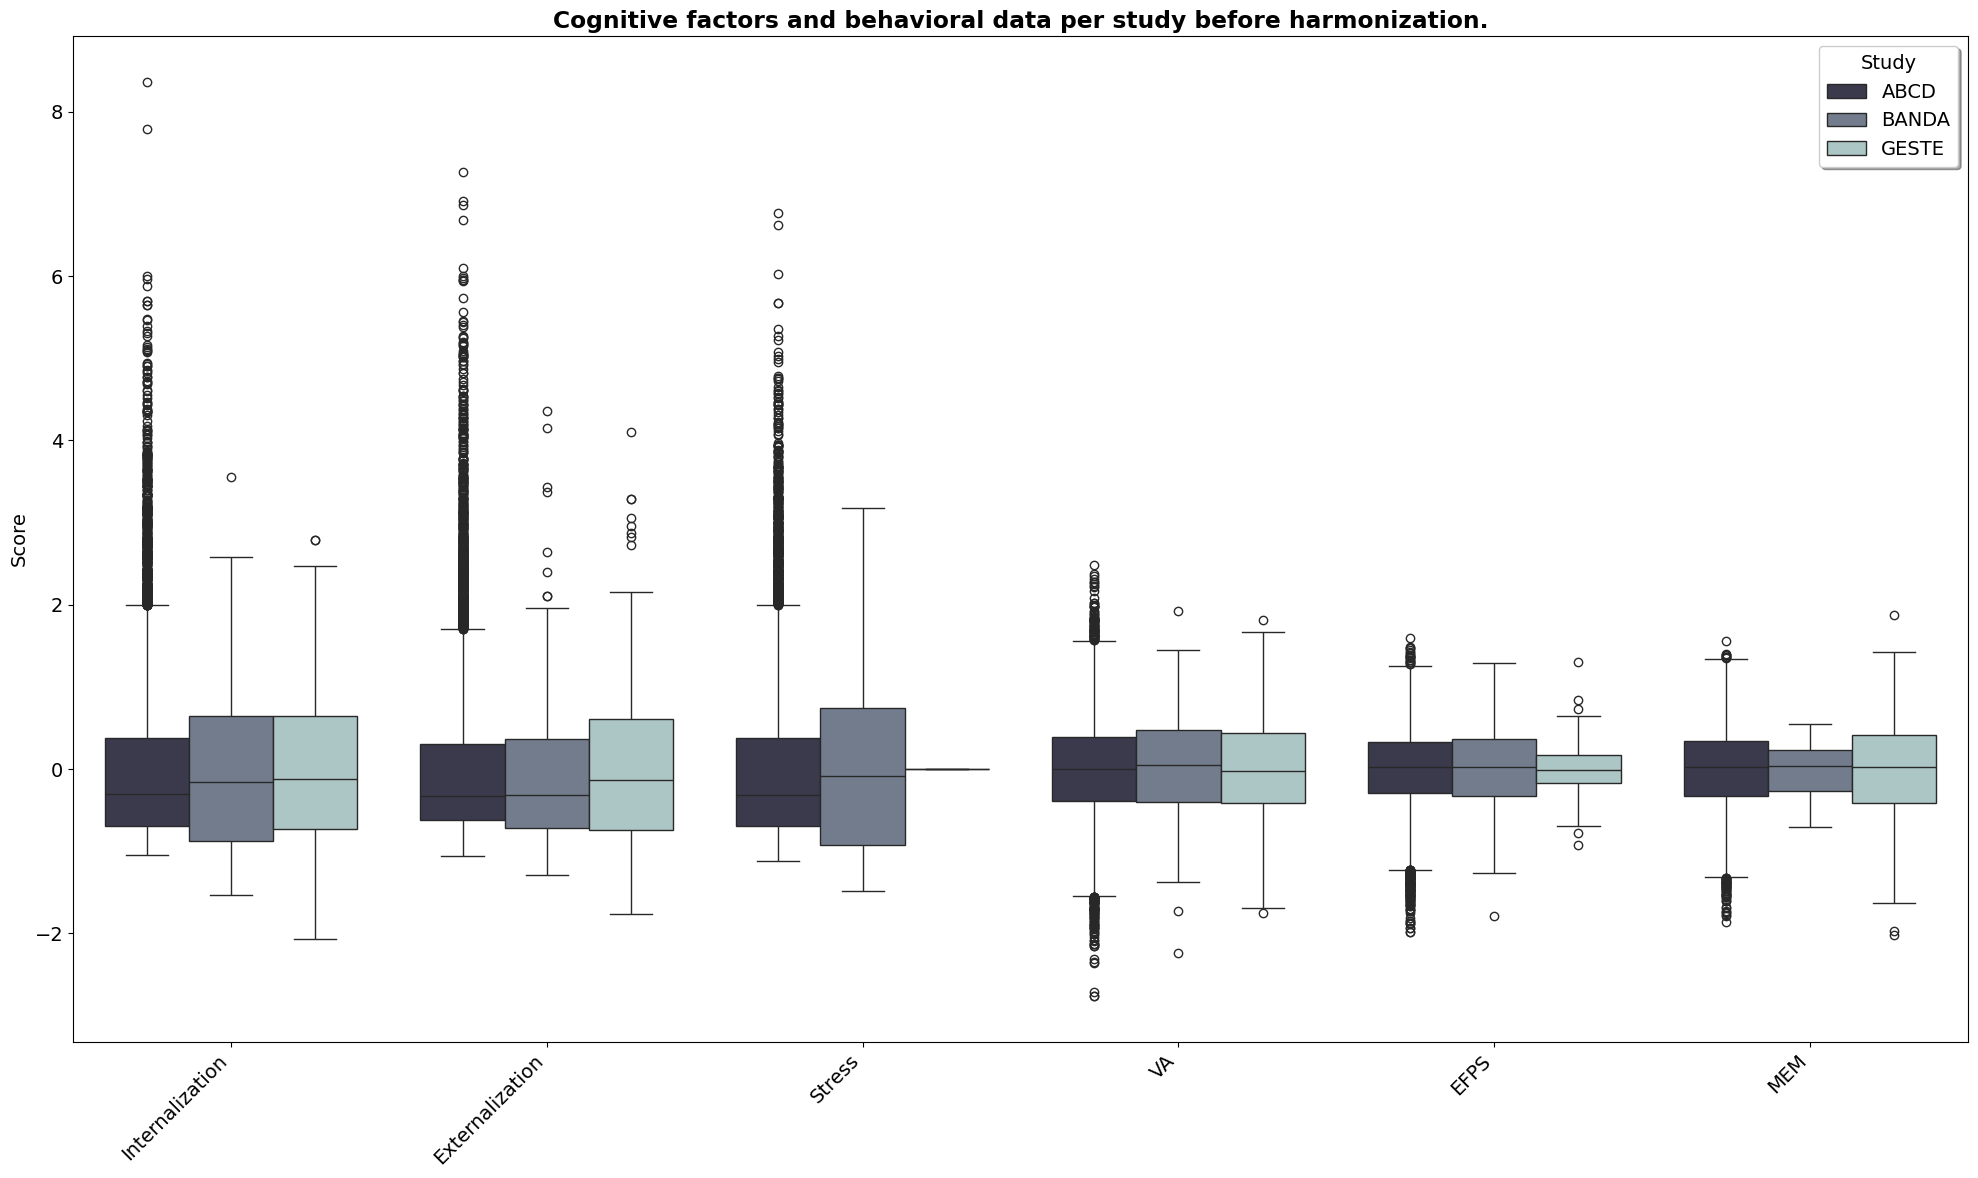

In [26]:
# Visualizing the data before harmonization.

# Melt the data for visualization.
data_for_harm_viz = data_for_harm.melt(id_vars=['Cohort'])

# Setting plotting parameters.
params = {
    "data": data_for_harm_viz,
    "x": "variable",
    "y": "value",
    "hue": "Cohort",
    "palette": "bone",
    "saturation": 0.8,
    "orient": "v",
}


with plt.rc_context(
        {"font.family": "Sans Serif",
         "font.size": 14, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    sns.boxplot(**params, ax=ax)

    # Customizing the plot.
    ax.set_title("Cognitive factors and behavioral data per study before harmonization.")
    ax.set_ylabel("Score")
    ax.set_xlabel("")
    ax.figure.autofmt_xdate(rotation=45, ha='right')
    ax.legend(loc="upper right", bbox_to_anchor=(1., 1.0), title="Study", title_fontsize="medium",
              shadow=True, fancybox=True)

    plt.tight_layout()
    plt.show() 

In [27]:
# Performing harmonization between studies.
covars = data_for_harm[["Cohort"]]

harmonized_merged = neuroCombat(data_for_harm.iloc[:, :-1].values.T.astype("float"), covars, batch_col="Cohort",
                                 eb=True, parametric=True, ref_batch="ABCD")

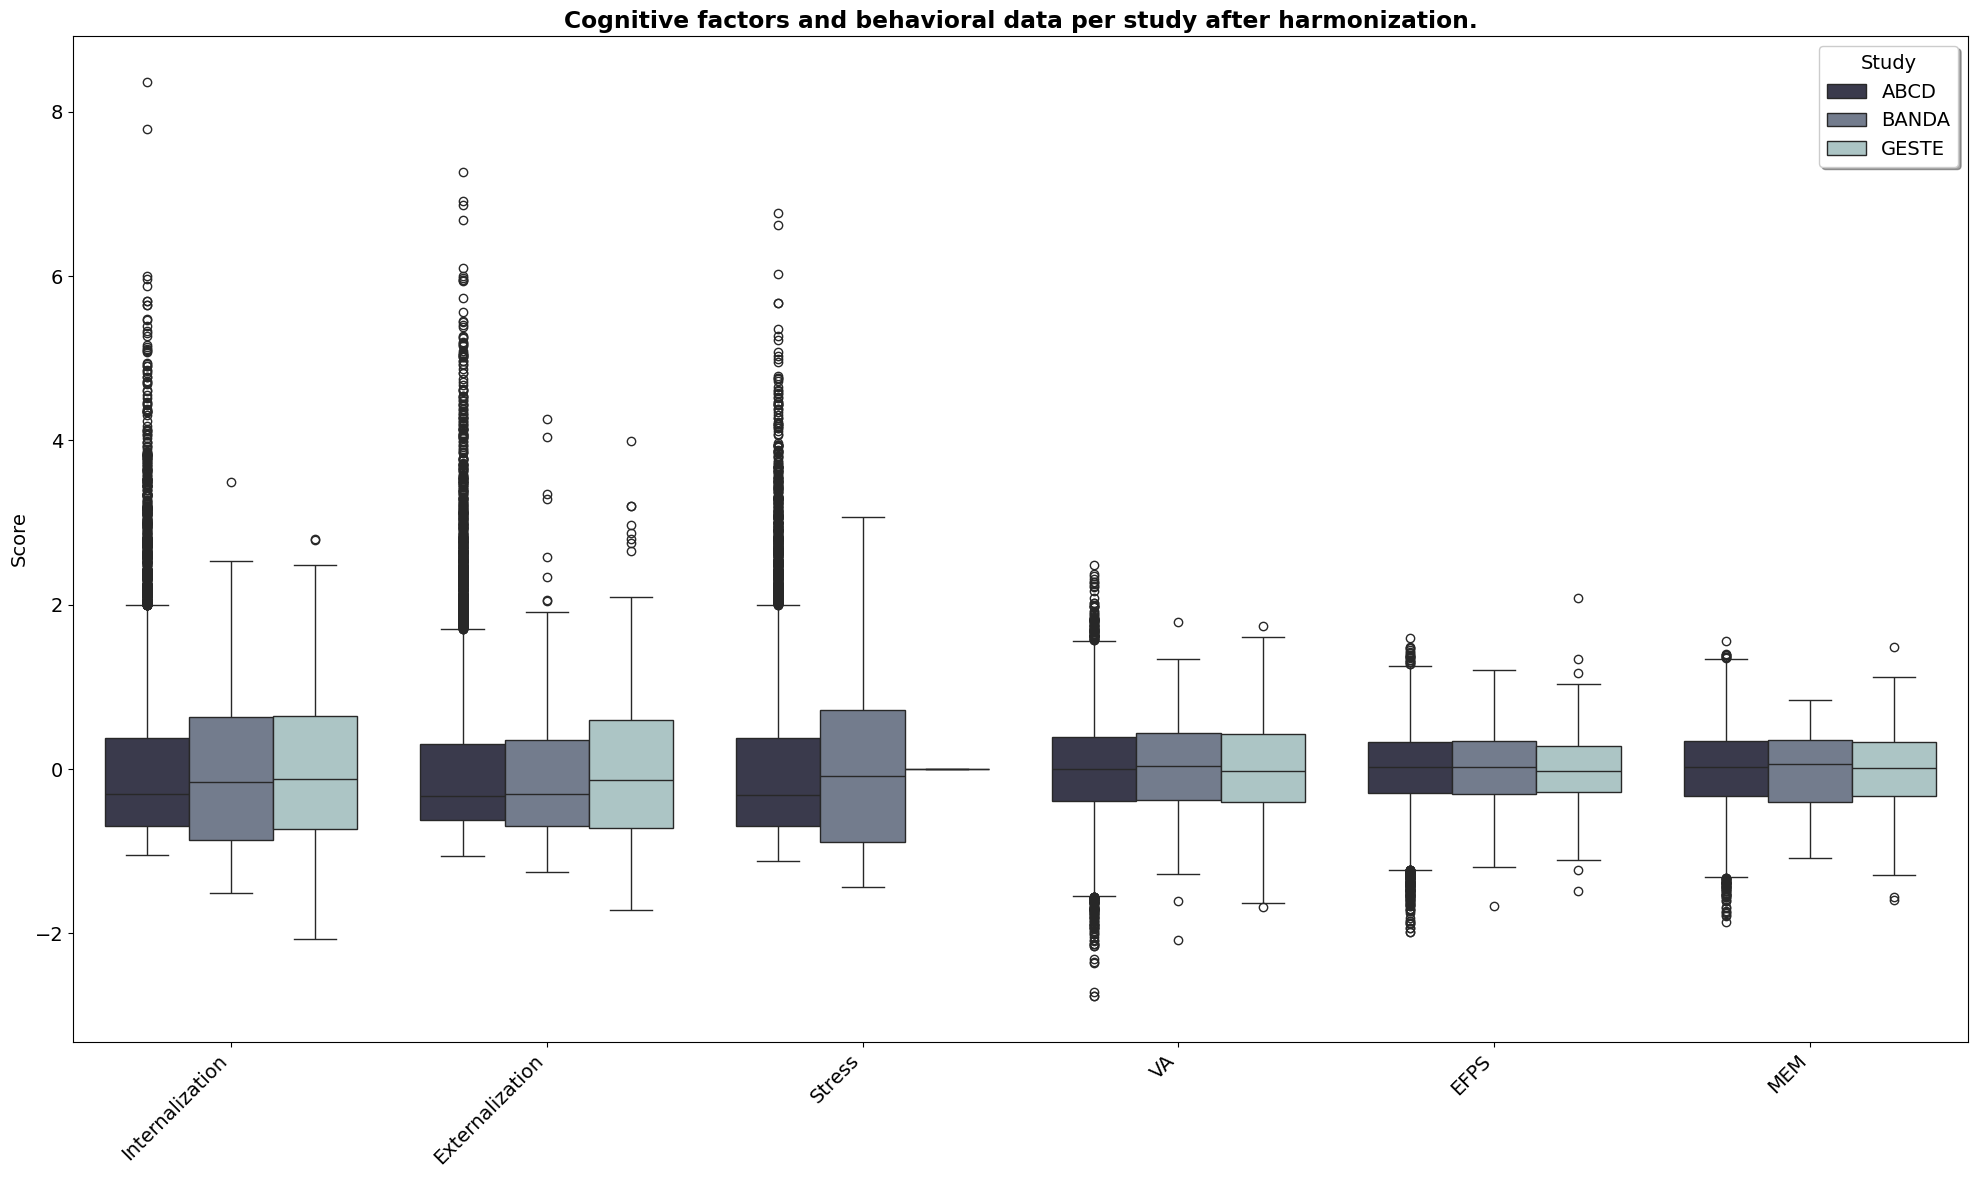

In [28]:
# Plotting the newly harmonized data.
data_post_harm = pd.DataFrame(harmonized_merged['data'].T, columns=vars)
data_post_harm = pd.concat([covars.reset_index(drop=True), data_post_harm], axis=1)

# Melt the data for visualization.
data_post_harm_viz = data_post_harm.melt(id_vars=['Cohort'])

# Setting plotting parameters.
params = {
    "data": data_post_harm_viz,
    "x": "variable",
    "y": "value",
    "hue": "Cohort",
    "palette": "bone",
    "saturation": 0.8,
    "orient": "v",
}

with plt.rc_context(
        {"font.family": "Sans Serif",
         "font.size": 14, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    sns.boxplot(**params, ax=ax)

    # Customizing the plot.
    ax.set_title("Cognitive factors and behavioral data per study after harmonization.")
    ax.set_ylabel("Score")
    ax.set_xlabel("")
    ax.figure.autofmt_xdate(rotation=45, ha='right')
    ax.legend(loc="upper right", bbox_to_anchor=(1.0, 1.0), title="Study", title_fontsize="medium",
              shadow=True, fancybox=True)

    plt.tight_layout()
    plt.show()

In [21]:
# Merge the harmonized data with the original data.
abcd_to_add = data_post_harm[data_post_harm.loc[:, 'Cohort'] == 'ABCD'].reset_index(drop=True)
abcd_harmonized = pd.concat([abcd_cfa.drop(columns=vars),
                             abcd_to_add], axis=1)
abcd_harmonized.to_excel(f'{output_dir}/abcd_data_preprocessed.xlsx', index=False, header=True)

banda_to_add = data_post_harm[data_post_harm.loc[:, 'Cohort'] == 'BANDA'].reset_index(drop=True)
banda_harmonized = pd.concat([banda_cfa.drop(columns=vars),
                              banda_to_add], axis=1)
banda_harmonized.to_excel(f'{output_dir}/banda_data_preprocessed.xlsx', index=False, header=True)

# Dropping the empty column used to reproduce the Stress problems score.
geste_to_add = data_post_harm[data_post_harm.loc[:, 'Cohort'] == 'GESTE'].reset_index(drop=True)
geste_to_add.drop(columns='Stress', inplace=True)
geste_harmonized = pd.concat([geste_cfa.drop(columns=vars),
                              geste_to_add], axis=1)

#### **Imputating stress variables within the GESTE study.**

Since GESTE does not have a Stress variable, we will fit a KNN (k-Nearest Neighbor) imputation model on the ABCD dataset, and use it to impute a new Stress variable in the GESTE study. 

First steps is to test the optimal number of neighbors to use by running multiple values and evaluating the correlation with ground truth values. Then, impute the stress variable with using the optimal number of neigbors.

In [22]:
# Small function to convert a columns to NaNs.
def convert_to_nan(x):
    return np.nan

#### **Optimal number of neighbors to impute the GESTE dataset.**

In [23]:
# Imputing existing variables in the GESTE study.
# Create a loop that test out various K values for the KNN imputer.
k_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400]
results = []

for k in k_values:
    KNN_partial = KNNImputer(n_neighbors=k, weights='distance',
                             metric='nan_euclidean', keep_empty_features=True)
    KNN_partial.fit(abcd_harmonized[['Internalization', 'Externalization', 'VA', 'EFPS', 'MEM']])

    dict = {}
    for var in ['Internalization', 'Externalization', 'VA', 'EFPS', 'MEM']:
        oneout = geste_harmonized[['Internalization', 'Externalization', 'VA', 'EFPS', 'MEM']]
        oneout.loc[:, var] = oneout[var].apply(convert_to_nan)
        imputed = pd.DataFrame(KNN_partial.transform(oneout), columns=oneout.columns)
        dict[f'{var}_imputed'] = imputed[var].values

    dict['subjectkey'] = geste_harmonized['subjectkey']
    input_valid = merge_dataframes({"geste": geste_harmonized, "imputed": pd.DataFrame(dict)}, index="subjectkey")

    r_int = stats.pearsonr(x=input_valid.Internalization, y=input_valid.Internalization_imputed)
    r_ext = stats.pearsonr(x=input_valid.Externalization, y=input_valid.Externalization_imputed)
    r_va = stats.pearsonr(x=input_valid.VA, y=input_valid.VA_imputed)
    r_efps = stats.pearsonr(x=input_valid.EFPS, y=input_valid.EFPS_imputed)
    r_wm = stats.pearsonr(x=input_valid.MEM, y=input_valid.MEM_imputed)

    results.append([k, r_int[0], r_ext[0], r_va[0], r_efps[0], r_wm[0]])

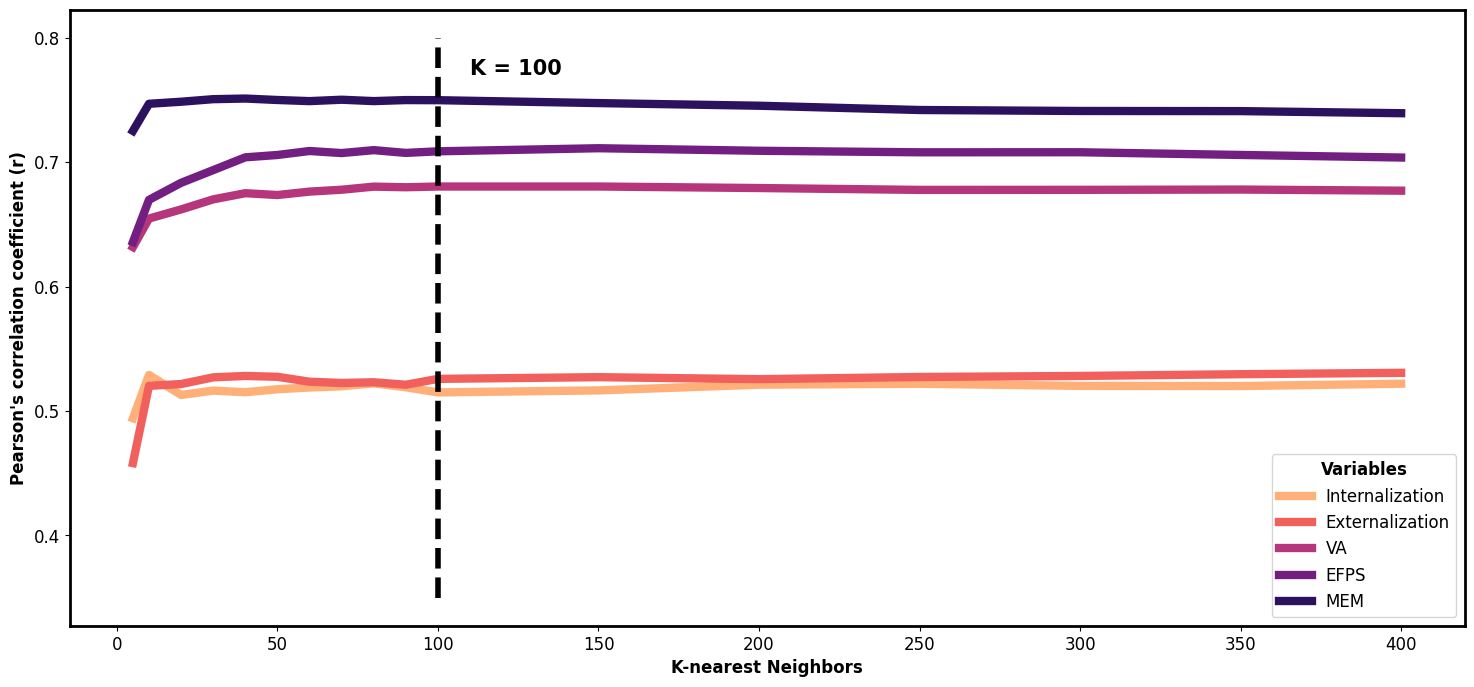

In [26]:
# Plot those results in a line plot.
results_df = pd.DataFrame(results, columns=['K', 'Internalization', 'Externalization', 'VA', 'EFPS', 'MEM'])
results_df = results_df.melt(id_vars=['K'], value_vars=results_df.columns[1:])

with plt.rc_context(
        {"font.family": "Sans Serif",
         "font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
         }
        ):
        fig, ax = plt.subplots(1, figsize=(18, 8))
        sns.lineplot(x='K', y='value', hue='variable', data=results_df, ax=ax,
                     palette='magma_r', linewidth=6)
        plt.plot([100,100], [0.35, 0.80], 'k--', lw=4)
        plt.text(110, 0.77, 'K = 100', fontsize=15, weight='bold')
        ax.legend(title='Variables', loc='best',
                  title_fontproperties={'weight': 'bold', 'size': 12})
        ax.spines[['left', 'right', 'top', 'bottom']].set(linewidth=2)
        ax.set_ylabel("Pearson's correlation coefficient (r)", fontdict={"fontweight": "bold"})
        ax.set_xlabel("K-nearest Neighbors", fontdict={"fontweight": "bold"})
        
        plt.show()

In [58]:
# Impute the data using the optimal K value.
KNN_banda = KNNImputer(n_neighbors=100, weights='distance',
                       metric='nan_euclidean', keep_empty_features=True)
KNN_banda.fit(abcd_harmonized[['Internalization', 'Externalization', 'VA', 'EFPS', 'MEM']])

dict = {}
for var in ['Internalization', 'Externalization', 'VA', 'EFPS', 'MEM']:
    oneout = geste_harmonized[['Internalization', 'Externalization', 'VA', 'EFPS', 'MEM']]
    oneout.loc[:, var] = oneout[var].apply(convert_to_nan)
    inputed = pd.DataFrame(KNN_banda.transform(oneout), columns=oneout.columns)
    dict[f'{var}_imputed'] = inputed[var].values

dict['subjectkey'] = geste_harmonized['subjectkey']
input_valid = merge_dataframes({"geste": geste_harmonized, "imputed": pd.DataFrame(dict)}, index="subjectkey")

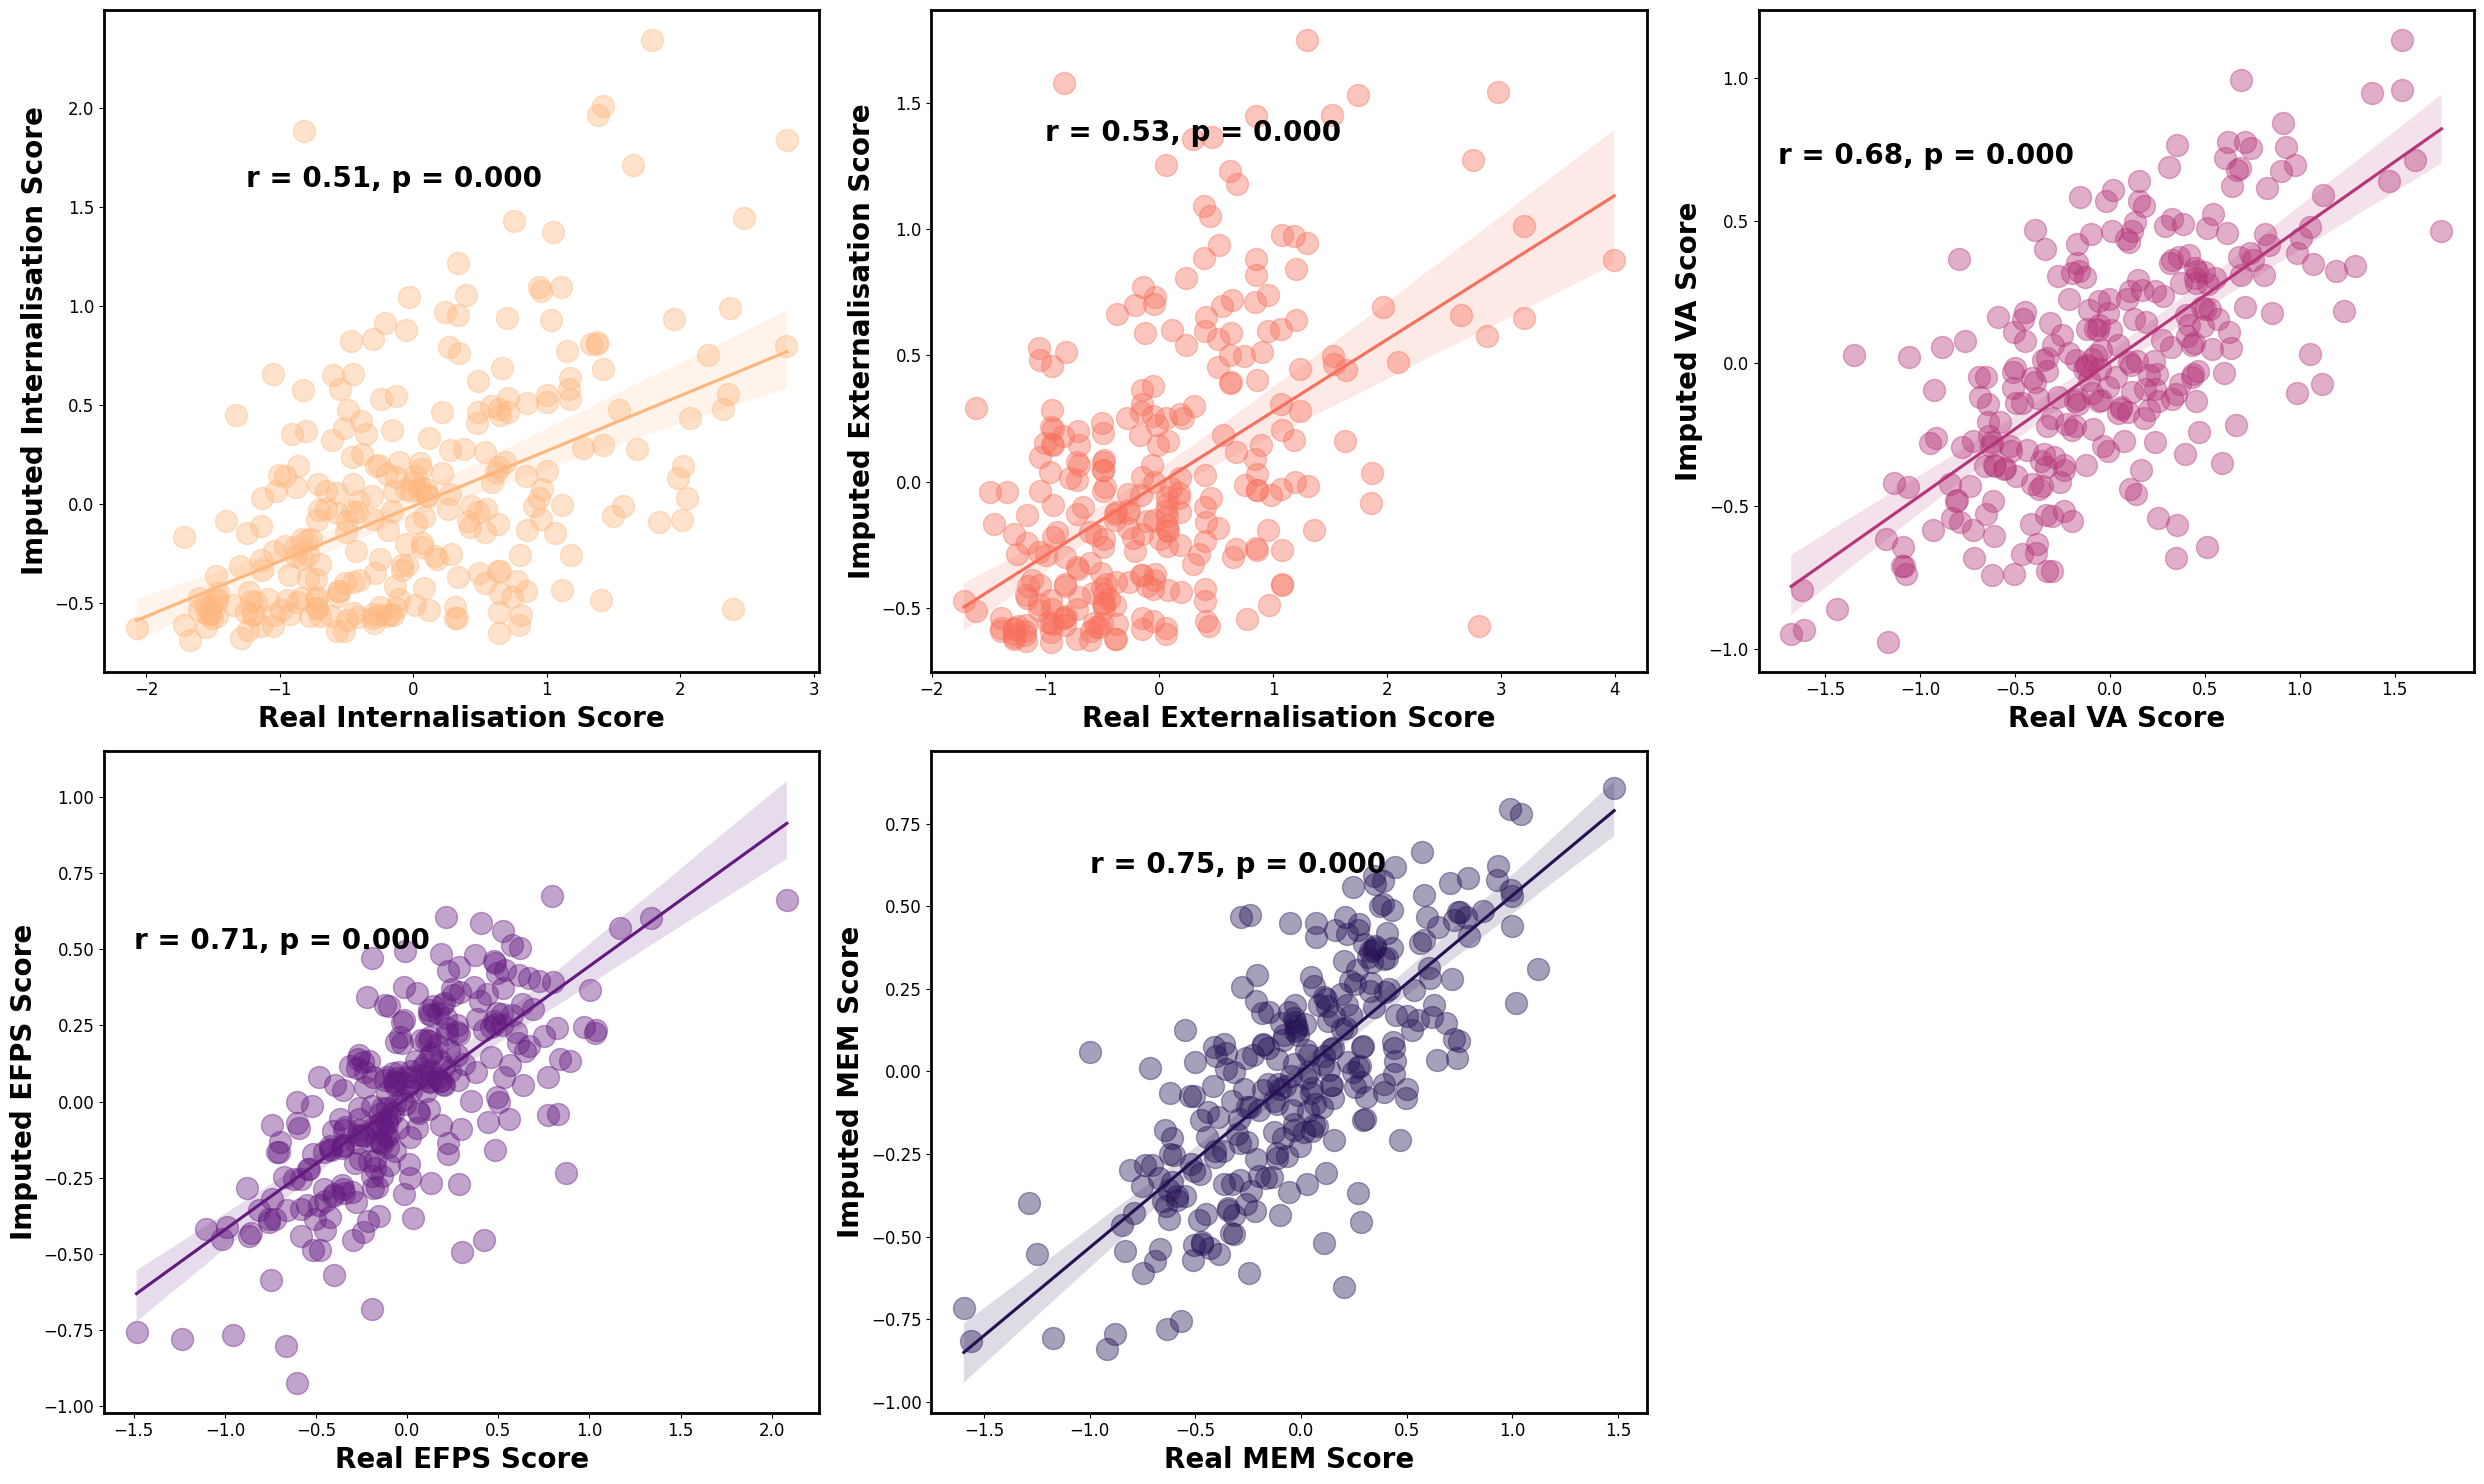

In [59]:
# Validate using a leave-one-out approach.
r_int = stats.pearsonr(x=input_valid.Internalization, y=input_valid.Internalization_imputed)
r_ext = stats.pearsonr(x=input_valid.Externalization, y=input_valid.Externalization_imputed)
r_va = stats.pearsonr(x=input_valid.VA, y=input_valid.VA_imputed)
r_efps = stats.pearsonr(x=input_valid.EFPS, y=input_valid.EFPS_imputed)
r_wm = stats.pearsonr(x=input_valid.MEM, y=input_valid.MEM_imputed)

with plt.rc_context(
        {"font.family": "Sans Serif",
         "font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    
    fig, ax = plt.subplots(2, 3, figsize=(25, 15))
    sns.regplot(ax=ax[0, 0], x='Internalization', y='Internalization_imputed',
                data=input_valid,
                ci=95, color=plt.cm.magma_r(0.15),
                marker='o',
                robust=True,
                scatter_kws={'s': 250, 'alpha': 0.4, "color": plt.cm.magma_r(0.15)})
    
    ax[0, 0].spines[["left", "right", "bottom", "top"]].set(linewidth=2)
    ax[0, 0].set_ylabel("Imputed Internalisation Score", fontdict={"fontweight": "bold", 'size': 20})
    ax[0, 0].set_xlabel("Real Internalisation Score", fontdict={"fontweight": "bold", 'size': 20})
    
    ax[0, 0].text(-1.25, 1.6, 'r = {:.2f}, p = {:.3f}'.format(r_int[0], r_int[1]), fontsize=20, weight='bold')
    
    sns.regplot(ax=ax[0, 1], x='Externalization', y='Externalization_imputed',
                data=input_valid,
                ci=95, color=plt.cm.magma_r(0.3),
                marker='o',
                robust=True,
                scatter_kws={'s': 250, 'alpha': 0.4, "color": plt.cm.magma_r(0.3)})
    
    ax[0, 1].spines[["left", "right", "bottom", "top"]].set(linewidth=2)
    ax[0, 1].set_ylabel("Imputed Externalisation Score", fontdict={"fontweight": "bold", 'size': 20})
    ax[0, 1].set_xlabel("Real Externalisation Score", fontdict={"fontweight": "bold", 'size': 20})
    
    ax[0, 1].text(-1, 1.35, 'r = {:.2f}, p = {:.3f}'.format(r_ext[0], r_ext[1]), fontsize=20, weight='bold')

    sns.regplot(ax=ax[0, 2], x='VA', y='VA_imputed',
                data=input_valid,
                ci=95, color=plt.cm.magma_r(0.5),
                marker='o',
                robust=True,
                scatter_kws={'s': 250, 'alpha': 0.4, "color": plt.cm.magma_r(0.5)})
    
    ax[0, 2].spines[["left", "right", "bottom", "top"]].set(linewidth=2)
    ax[0, 2].set_ylabel("Imputed VA Score", fontdict={"fontweight": "bold", 'size': 20})
    ax[0, 2].set_xlabel("Real VA Score", fontdict={"fontweight": "bold", 'size': 20})
    
    ax[0, 2].text(-1.75, 0.7, 'r = {:.2f}, p = {:.3f}'.format(r_va[0], r_va[1]), fontsize=20, weight='bold')
    
    sns.regplot(ax=ax[1, 0], x='EFPS', y='EFPS_imputed',
                data=input_valid,
                ci=95, color=plt.cm.magma_r(0.7),
                marker='o',
                robust=True,
                scatter_kws={'s': 250, 'alpha': 0.4, "color": plt.cm.magma_r(0.7)})
    
    ax[1, 0].spines[["left", "right", "bottom", "top"]].set(linewidth=2)
    ax[1, 0].set_ylabel("Imputed EFPS Score", fontdict={"fontweight": "bold", 'size': 20})
    ax[1, 0].set_xlabel("Real EFPS Score", fontdict={"fontweight": "bold", 'size': 20})
    
    ax[1, 0].text(-1.5, 0.50, 'r = {:.2f}, p = {:.3f}'.format(r_efps[0], r_efps[1]), fontsize=20, weight='bold')
    
    sns.regplot(ax=ax[1, 1], x='MEM', y='MEM_imputed',
                data=input_valid,
                ci=95, color=plt.cm.magma_r(0.85),
                marker='o',
                robust=True,
                scatter_kws={'s': 250, 'alpha': 0.4, "color": plt.cm.magma_r(0.85)})
    
    ax[1, 1].spines[["left", "right", "bottom", "top"]].set(linewidth=2)
    ax[1, 1].set_ylabel("Imputed MEM Score", fontdict={"fontweight": "bold", 'size': 20})
    ax[1, 1].set_xlabel("Real MEM Score", fontdict={"fontweight": "bold", 'size': 20})
    
    ax[1, 1].text(-1., 0.60, 'r = {:.2f}, p = {:.3f}'.format(r_wm[0], r_wm[1]), fontsize=20, weight='bold')
    
    ax[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

#### **Final Imputation of the stress variable in the GESTE dataset.**

Based on the previously optimized number of neighbors, we will use 100 neighbors to impute the stress variable, then merged the new variable with the previously harmonized dataset.

In [28]:
# Setting up the KNN imputer using the ABCD data using 100 neighbors.
KNN = KNNImputer(n_neighbors=100, weights='distance',
                 metric='nan_euclidean', keep_empty_features=True)
KNN.fit(abcd_harmonized[['Internalization', 'Externalization', 'Stress', 'VA', 'EFPS', 'MEM']])

KNNImputer(keep_empty_features=True, n_neighbors=100, weights='distance')

In [29]:
# Extract the variables from GESTE and append an empty column for the stress variable.
geste_harmonized.loc[:, 'Stress'] = np.nan

# Impute the data using the KNN imputer.
geste_imp = KNN.transform(geste_harmonized[['Internalization', 'Externalization', 'Stress', 'VA', 'EFPS', 'MEM']])

# Merge the imputed data with the original data.
geste_imp = pd.DataFrame(geste_imp, columns=['Internalization', 'Externalization', 'Stress', 'VA', 'EFPS', 'MEM'])
geste_imp = pd.concat([geste_harmonized.drop(columns=['Internalization', 'Externalization', 'Stress', 'VA', 'EFPS', 'MEM']),
                       geste_imp], axis=1)

# Saving the imputed data.
geste_imp.to_excel(f'{output_dir}/geste_data_preprocessed.xlsx', index=False, header=True)

#### **Additional validation of the quality of the stress-imputed variable within the GESTE study.**

To confirm the validity of the imputed stress problems score in the GESTE cohort, we evaluated the correlation between the imputed values and the depression composite score from the Behavioral Assessment System for Children 3rd edition (BASC-3) parent rating scales, which reflect stress problems combined with general feelings of unhappiness and sadness.

In [27]:
# Load the depression data.
geste_neuro = load_df_in_any_format(f'{geste_base_dir}/Neurocognitive/neurocognitive_data.xlsx')

In [30]:
# Fetch the depression variable and merge it with the imputed data.
depression = geste_neuro[['record_id', 'basc3_dp_t']]
depression.columns = ['subjectkey', 'depression']

# Merge it with the imputed data.
geste_imp = merge_dataframes({"geste": geste_imp, "depression": depression}, index="subjectkey")

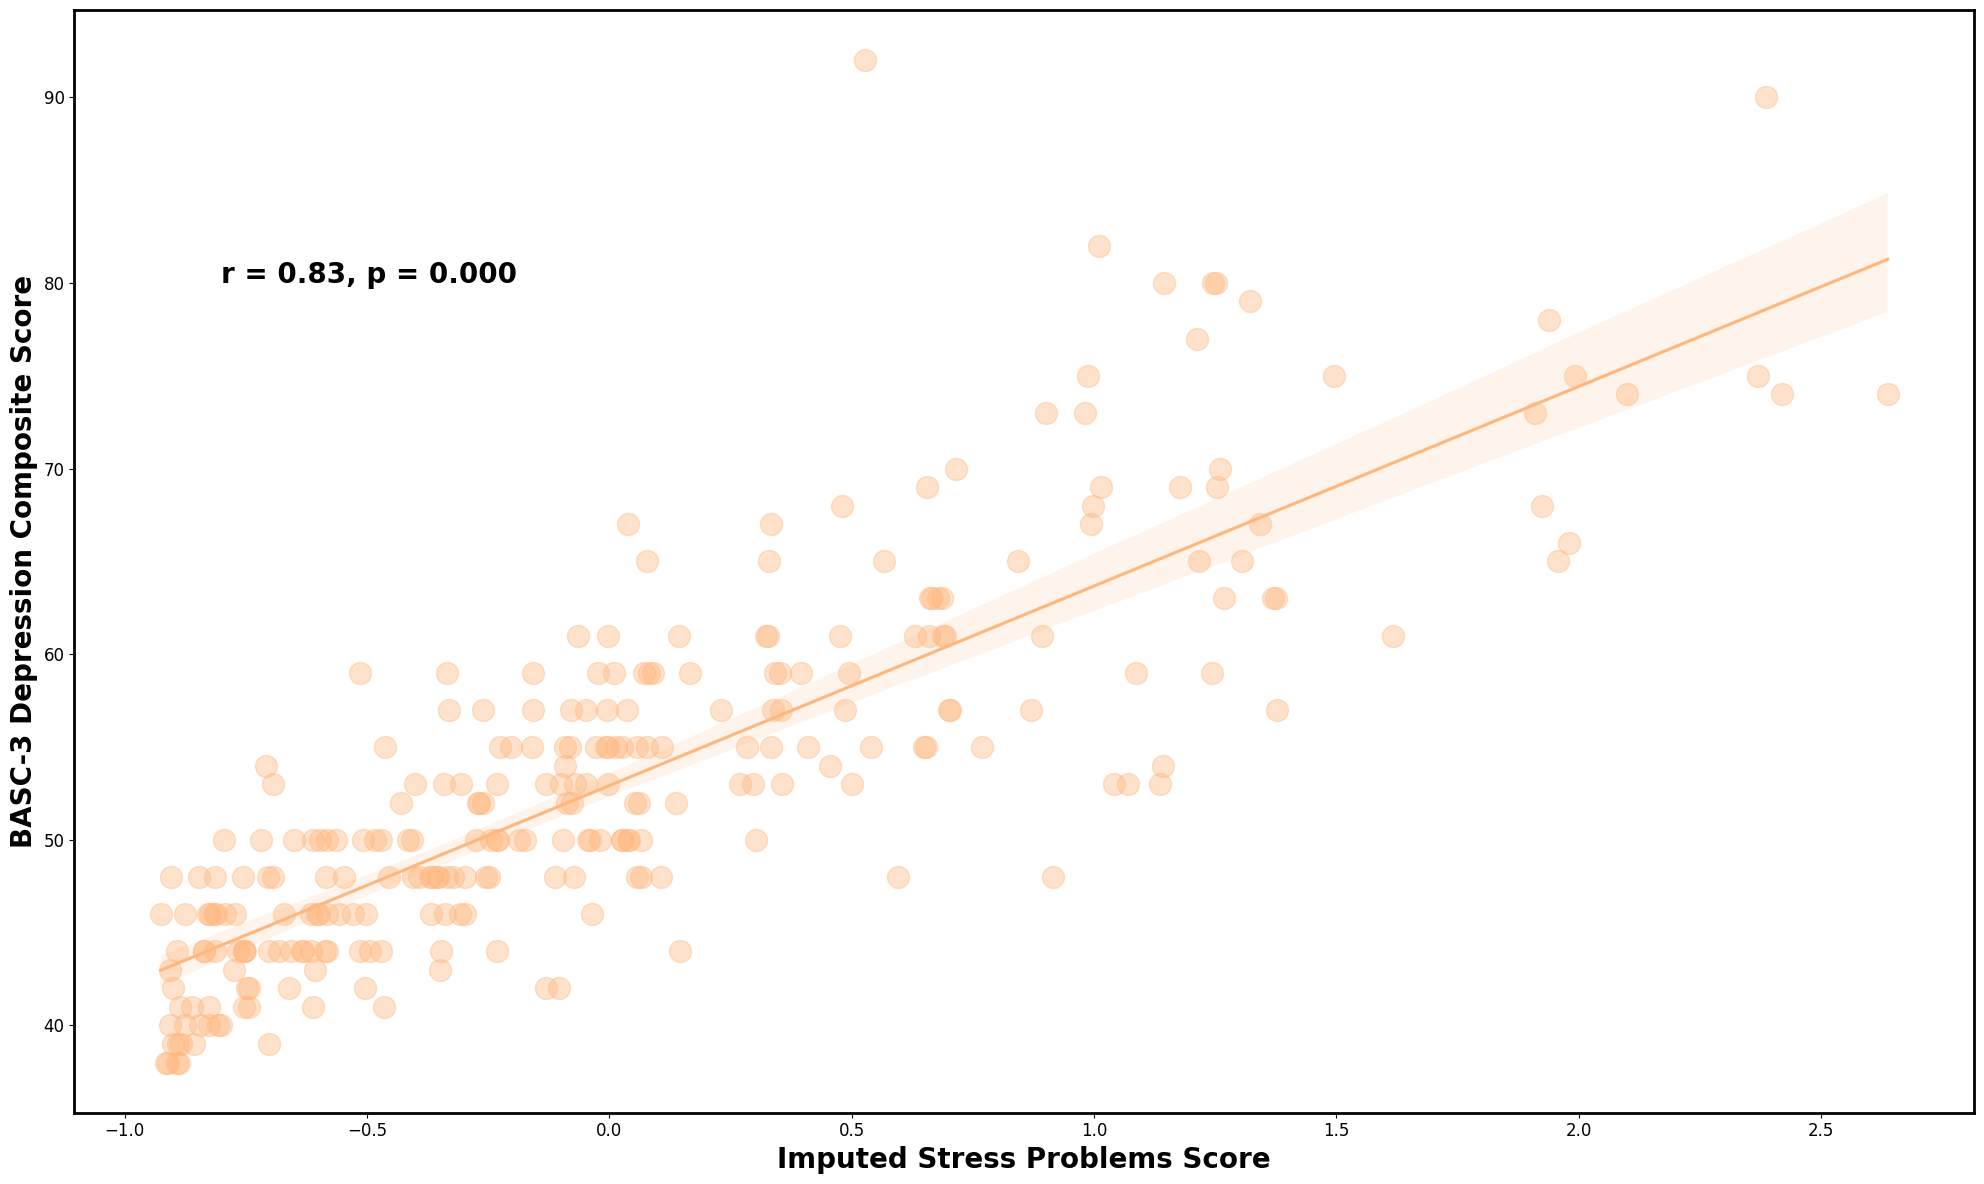

In [31]:
# Scatter plot of the depression variable against the imputed stress variable.
r_dep = stats.pearsonr(x=geste_imp.Stress, y=geste_imp.depression)

with plt.rc_context(
        {"font.family": "Sans Serif",
         "font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
        fig, ax = plt.subplots(1, 1, figsize=(20, 12))
        sns.regplot(ax=ax, x='Stress', y='depression',
                        data=geste_imp,
                        ci=95, color=plt.cm.magma_r(0.15),
                        marker='o',
                        robust=True,
                        scatter_kws={'s': 250, 'alpha': 0.4, "color": plt.cm.magma_r(0.15)})
        
        ax.spines[["left", "right", "bottom", "top"]].set(linewidth=2)
        ax.set_ylabel("BASC-3 Depression Composite Score", fontdict={"fontweight": "bold", 'size': 20})
        ax.set_xlabel("Imputed Stress Problems Score", fontdict={"fontweight": "bold", 'size': 20})
        
        ax.text(-0.8, 80, 'r = {:.2f}, p = {:.3f}'.format(r_dep[0], r_dep[1]), fontsize=20, weight='bold')

        plt.tight_layout()
        plt.show()